In [15]:
import copy

# import cProfile
import itertools

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.stats as st

import neuro_op as nop

In [16]:
nop.plot_setup()

In [17]:
# Reference input, to be adapted, just here for reference
input = dict(
    G=nop.build_random_network(N_nodes=100, N_neighbours=15),
    # G=nx.empty_graph(150),
    llf_nodes=st.norm,
    params_node=dict(
        loc=0,
        scale=10,
    ),
    sd_llf=1,
    llf_world=st.norm,
    params_world=dict(
        loc=0,
        scale=1,
    ),
    h=1,
    r=1,
    t0=0,
    t_max=50,
    t_sample=1,
    sampling=True,
    actInf=1,
    init_rngs=False,
    seed=False,
)

In [18]:
# i.g. sourced form
# 1. Dunbar 1993 (BEHAVIORAL AND BRAIN SCIENCES (1993) 16:4)
# 2. Dunbar 2008, https://doi.org/10.1037/1089-2699.12.1.7
# 3. Yellow (June 25, 2018)
# (4. Lazily extrapolate N, nn from (x_{n+1})_n = n*ln(n) with n_0 = )

nn = [10, (5, 15)]  # from 2
N = [
    1,  # for simple understanding
    2,  # for simple understanding
    150,  # from 1
    500,  # from 3
]

# MA0 )
nn_arr = np.round(
    np.concatenate(([1], np.arange(2, 11, 2), np.arange(30, 150, 30), [149])), 0
)

# MA1 )
sd_llf_arr = np.arange(0.25, 2.1, 0.25)
nn_arr = np.arange(2.5, 21, 2.5)

# MA2 )
sd_arr = np.arange(0.25, 2.1, 0.25)

# MA3 )
mu_arr = np.arange(0, 10.1, 2)
sd_arr = np.arange(1, 10.1, 1.5)
r_arr = np.arange(1, 10.1, 1.5)

In [19]:
# out1 = nop.run_ConjMu(**nop.input_ref_ConjMu)
out1 = nop.run_ConjMu(**input)

In [20]:
nop.export_hdf5(out1, "test.h5")

In [21]:
out1 = nop.import_hdf5("test.h5", True, True, True)

## Data analysis

Random data analysis test notebook of steps later used in thorough analysis.


#### Data analysis 1

Firstly, extract output values for further analysis:

In [22]:
for i in out1.keys():
    print(i)

world
G
N_events
t_end
t_start
t_exec
seed
nodesConjMu
mu_nodes
sd_nodes
kl_divs



Each node's posteriors are plotted. One should see nodes' posteriors of model parameters (in this case, $\mu$), to converge around the true value. If not, nodes may need more information to converge ($\rightarrow$ increase $t_{max}, h$).


(array([ 2.,  4.,  9., 13., 16., 19., 13.,  6.,  4.,  3.,  2.,  2.,  1.,
         2.,  1.,  1.,  0.,  0.,  0.,  2.]),
 array([0.00283976, 0.00496185, 0.00708394, 0.00920604, 0.01132813,
        0.01345023, 0.01557232, 0.01769442, 0.01981651, 0.02193861,
        0.0240607 , 0.0261828 , 0.02830489, 0.03042698, 0.03254908,
        0.03467117, 0.03679327, 0.03891536, 0.04103746, 0.04315955,
        0.04528165]),
 <BarContainer object of 20 artists>)

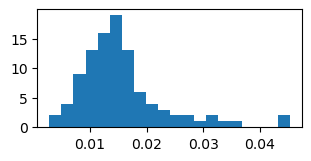

In [23]:
sigmas = []
for i in out1["nodesConjMu"]:
    sigmas += [i.params_node["scale"]]
fig, ax = plt.subplots()
ax.hist(sigmas, bins=20)

[[ 1.22373949e+01  7.80000000e+01  1.74365448e-01]
 [ 8.41490934e+00  4.30000000e+01  1.83272185e-01]
 [-4.02973106e+00  9.90000000e+01  1.40758970e+00]
 [-3.37880639e+00  4.30000000e+01  1.57268558e+00]
 [ 1.63401205e+01  8.00000000e+00  1.74007580e+00]
 [-4.08572320e+00  4.30000000e+01  2.44045282e+00]
 [ 4.15053100e-01 -1.00000000e+00  3.08826137e+00]
 [-1.32983193e+00  6.00000000e+01  3.35654809e+00]
 [-2.49552116e+00  4.30000000e+01  3.64684918e+00]
 [ 3.14988496e+00  5.80000000e+01  3.91055841e+00]
 [-1.50979107e+01  7.00000000e+00  3.97634853e+00]
 [-3.13610050e-02 -1.00000000e+00  4.66801207e+00]
 [-4.62450828e+00  6.00000000e+00  4.68801479e+00]
 [ 2.74047632e+00  9.00000000e+00  4.92481882e+00]
 [ 3.87159073e+00  6.70000000e+01  5.50506642e+00]
 [ 1.70605107e-01 -1.00000000e+00  5.97078164e+00]
 [-3.99749974e-01  6.70000000e+01  6.59485208e+00]
 [-1.97808915e-01  5.00000000e+00  6.96876678e+00]
 [ 5.21044956e-01 -1.00000000e+00  7.39683744e+00]
 [-3.85972999e-01 -1.00000000e+

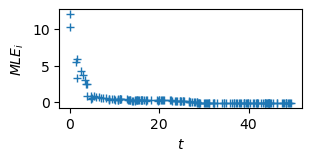

In [24]:
# Implement external sampling routine (or rather test if feasible)
k = 0
nody = out1["nodesConjMu"][k]
# mu_nody = np.array(out1["mu_nodes"])[:, k][1:]
#
fig, ax = plt.subplots()
# ax.plot(
#    np.arange(input["t0"], input["t_max"], input["t_sample"]),
#    mu_nody,
# )

mu, sig = input["params_node"].values()
sd_llf = input["sd_llf"]
x_in = np.array(nody.diary_in)
post_mu = x_in[:, 0]
post_sig = np.zeros_like(post_mu)

i = -1
post_mu[i], post_sig[i] = mu, sig
for i, _ in enumerate(x_in):
    post_mu[i] = (post_sig[i - 1] ** 2 * x_in[i, 0] + sd_llf**2 * post_mu[i - 1]) / (
        post_sig[i - 1] ** 2 + sd_llf**2
    )
    post_sig[i] = (1 / post_sig[i - 1] ** 2 + 1 / sd_llf**2) ** (-0.5)

# ax.set_ylim(-1, 1)
ax.plot(x_in[:, 2], post_mu, "+", alpha=1)
ax.set_xlabel("$t$")
ax.set_ylabel("$MLE_i$")

print(nody.diary_in)
# fig.savefig("graphics-output/TMP-mu_N1.png", dpi=1500)

(51, 100)
51


(-3.0, 3.0)

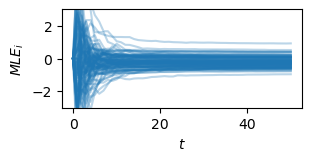

In [25]:
mu_arr = np.array(out1["mu_nodes"])
print(mu_arr.shape)
x = np.arange(input["t0"], input["t_max"] + input["t_sample"], input["t_sample"])
print(len(x))
fig, ax = plt.subplots()
for i, mu in enumerate(mu_arr.T):
    ax.plot(x, mu, alpha=0.3, label=f"$\mu_{i}$", color="tab:blue")
    ax.set_xlabel("$t$")
    ax.set_ylabel("$MLE_i$")
ax.set_ylim(-3, 3)
# ax.set_yscale("log")
# ax.loglog()
# ax.legend()
# fig.savefig("./graphics-output/TMP-mu_nodes.png", dpi=1500)